<a href="https://colab.research.google.com/github/AROMAL2059/-UEL-Machine-Learning-with-big-data/blob/main/Week_7%3DTwitter_Sentiment_Prediction_Perceptronipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=0ef62cb53bb61b267ae00716075a4c948d075798671dda3fbc76b1d37c5b54fe
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark ML basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# importing required libraries
#!pip install OneHotEncoder

from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.streaming import StreamingContext
import pyspark.sql.types as tp
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer
#from pyspark.sql import Row

# define the schema
my_schema = tp.StructType([
  tp.StructField(name= 'id',          dataType= tp.IntegerType(),  nullable= True),
  tp.StructField(name= 'label',       dataType= tp.IntegerType(),  nullable= True),
  tp.StructField(name= 'tweet',       dataType= tp.StringType(),   nullable= True)
])


In [ ]:
import pandas
import warnings
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = '10'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

# Give path of file
dataset_file = "/content/twitter_sentiments.csv"

# read the dataset
dataset = spark.read.csv(dataset_file, inferSchema=True, header=True)



# view the data
dataset.show(5)

# print the schema of the file
dataset.printSchema()

+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
+---+-----+--------------------+
only showing top 5 rows

root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)



In [ ]:
# remove null values
dataset.na.fill(0).show()

print(dataset.tail(5))


+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
|  6|    0|[2/2] huge fan fa...|
|  7|    0| @user camping to...|
|  8|    0|the next school y...|
|  9|    0|we won!!! love th...|
| 10|    0| @user @user welc...|
| 11|    0| â #ireland con...|
| 12|    0|we are so selfish...|
| 13|    0|i get to see my d...|
| 14|    1|@user #cnn calls ...|
| 15|    1|no comment!  in #...|
| 16|    0|ouch...junior is ...|
| 17|    0|i am thankful for...|
| 18|    1|retweet if you ag...|
| 19|    0|its #friday! ð...|
| 20|    0|as we all know, e...|
+---+-----+--------------------+
only showing top 20 rows

[Row(id=31958, label=0, tweet='ate @user isz that youuu?ð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8dâ\x9d¤ï¸\

In [ ]:
# define stage 1: tokenize the tweet text
stage_1 = RegexTokenizer(inputCol= 'tweet' , outputCol= 'tokens', pattern= '\\W')

# define stage 2: remove the stop words
stage_2 = StopWordsRemover(inputCol= 'tokens', outputCol= 'filtered_words')

# define stage 3: create a word vector of the size 100
stage_3 = Word2Vec(inputCol= 'filtered_words', outputCol= 'vector', vectorSize= 100)

In [ ]:
#Train, test split
train, test = dataset.randomSplit([0.8, 0.9], seed=12345)

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

#layers = [100, 2]

layers = [100, 101, 100, 100, 100, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=10,
                                         featuresCol= 'vector',
                                         layers=layers,
                                         labelCol= 'label',
                                         stepSize = 0.01,
                                         seed=1234)

In [ ]:
# setup the pipeline
pipeline = Pipeline(stages= [stage_1, stage_2, stage_3, trainer])

In [ ]:

# Fit the pipeline to training documents.
mlp_model = pipeline.fit(train)
predictions_test = mlp_model.transform(test)
predictions_train = mlp_model.transform(train)

In [ ]:
#Get some sample predictions
predictions_test.select('tweet','label','prediction').show(20)

+--------------------+-----+----------+
|               tweet|label|prediction|
+--------------------+-----+----------+
| factsguide: soci...|    0|       0.0|
|[2/2] huge fan fa...|    0|       0.0|
| @user camping to...|    0|       0.0|
| @user @user welc...|    0|       0.0|
|i get to see my d...|    0|       0.0|
|@user #cnn calls ...|    1|       0.0|
|ouch...junior is ...|    0|       0.0|
|i am thankful for...|    0|       0.0|
|retweet if you ag...|    1|       0.0|
|its #friday! ð...|    0|       0.0|
|sad little dude.....|    0|       0.0|
| @user #tgif   #f...|    0|       0.0|
|beautiful sign by...|    0|       0.0|
|50 people went to...|    0|       0.0|
|it was a hard mon...|    0|       0.0|
|it's unbelievable...|    1|       0.0|
|morning~~ #travel...|    0|       0.0|
|i am thankful for...|    0|       0.0|
|when you finally ...|    0|       0.0|
|lovely echeveria ...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_test = evaluator.evaluate(predictions_test)
accuracy_train = evaluator.evaluate(predictions_train)

print("Test Error =  " , (1 - accuracy_test))
print("Test Accuracy = " , (accuracy_test))

print("Training Error =  " , (1 - accuracy_train))
print("Training Accuracy  = " , (accuracy_train))

predictions_test.printSchema()
summary = predictions_test.summary
print(summary)


Test Error =   0.06975920679886682
Test Accuracy =  0.9302407932011332
Training Error =   0.07058196830470098
Training Accuracy  =  0.929418031695299
root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- vector: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

<bound method DataFrame.summary of DataFrame[id: int, label: int, tweet: string, tokens: array<string>, filtered_words: array<string>, vector: vector, rawPrediction: vector, probability: vector, prediction: double]>


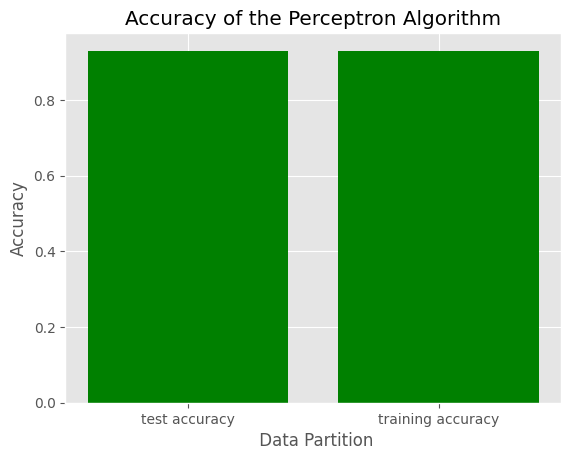

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = ['test accuracy', 'training accuracy']
accuracy = [accuracy_test, accuracy_train]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='green')
plt.xlabel(" Data Partition")
plt.ylabel("Accuracy")
plt.title("Accuracy of the Perceptron Algorithm")

plt.xticks(x_pos, x)

plt.show()